# Completeness Fit

Fit a completeness equation for single field images:
$$
\rm C(m) = \frac{A}{1+exp\left( \frac{m-m_{50}}{\rho} \right)}
$$

See Eq. 7 from (Martin et al. 2016); https://ui.adsabs.harvard.edu/abs/2016ApJ...833..167M/abstract



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('whitegrid')

In [2]:
# from scipy.stats import chisquare


## Completeness Equation

In [3]:
def completeness_formula(m, A=0.94, m50=24.88, rho=0.65):
    """ Completeness functional form
    See eq 7 from Martin et al. 2016
    """
    denominator = 1+np.exp((m-m50)/rho)
    res = A/denominator
    return res
    

In [4]:
A_fix, m50_fix, rho_fix = 0.94, 24.88, 0.65

mmin, mmax = 20, 28.5
mvec = np.linspace(mmin, mmax, 200)


Text(0.5, 1.0, 'Completeness Function: $\\rm m_{50}$')

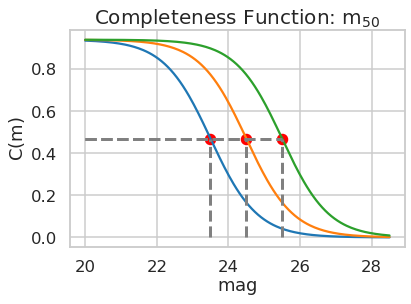

In [5]:
for mii in [23.5, 24.5, 25.5]:
    plt.plot(mvec, completeness_formula(mvec, m50=mii))
    plt.plot([mmin, mii], [0.5*A_fix, 0.5*A_fix],'--',lw=3,color='gray')
    plt.plot([mii, mii], [0.0, 0.5*A_fix],'--',lw=3,color='gray')
    plt.scatter([mii],[0.5*A_fix],color='r',s=100)

plt.xlabel(r'$\rm mag$')
plt.ylabel(r'$\rm C(m)$')
plt.title(r'Completeness Function: $\rm m_{50}$',fontsize=20)

Text(0.5, 1.0, 'Completeness Function: $\\rm \\rho$')

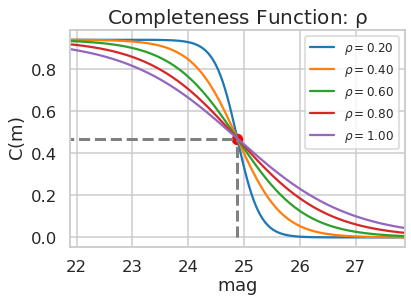

In [6]:
for rii in [0.2, 0.4, 0.6, 0.8, 1.0]:
    plt.plot(mvec, completeness_formula(mvec, rho=rii), label=r'$\rho =%.2f$'%(rii))
plt.plot([mmin, m50_fix], [0.5*A_fix, 0.5*A_fix],'--',lw=3,color='gray')
plt.plot([m50_fix, m50_fix], [0.0, 0.5*A_fix],'--',lw=3,color='gray')
plt.scatter([m50_fix],[0.5*A_fix],color='r',s=100)
plt.legend(fontsize=12)
plt.xlim(m50_fix-3., m50_fix+3.)
plt.xlabel(r'$\rm mag$')
plt.ylabel(r'$\rm C(m)$')
plt.title(r'Completeness Function: $\rm \rho$',fontsize=20)

Text(0.5, 1.0, 'Completeness Function: $\\rm A$')

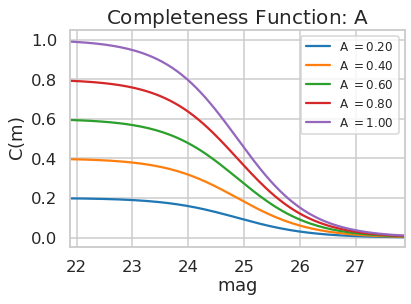

In [7]:
for aii in [0.2, 0.4, 0.6, 0.8, 1.0]:
    plt.plot(mvec, completeness_formula(mvec, A=aii), label=r'A $=%.2f$'%(aii))
    # plt.plot([mmin, m50_fix], [0.5*aii, 0.5*aii],'--',lw=3,color='gray')
    # plt.plot([m50_fix, m50_fix], [0.0, 0.5*aii],'--',lw=3,color='gray')
    #plt.scatter([m50_fix],[0.5*aii],color='k',s=100)
plt.legend(fontsize=12)
plt.xlim(m50_fix-3., m50_fix+3.)
plt.xlabel(r'$\rm mag$')
plt.ylabel(r'$\rm C(m)$')
plt.title(r'Completeness Function: $\rm A$',fontsize=20)

## Fiting Functions

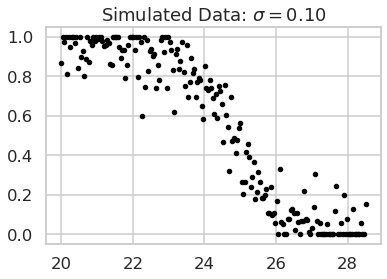

In [8]:
args = [A_fix, m50_fix, rho_fix]
scatter = 0.1

x = mvec
y = completeness_formula(mvec, *args) + scatter*np.random.normal(size=len(mvec))
y = np.where(y>1., 1, y)
y = np.where(y<0., 0., y)

plt.title(r'Simulated Data: $\sigma=%.2f$'%(scatter))
plt.plot(x, y, 'k.')

In [9]:
## fit equation
from scipy.optimize import curve_fit

popt, pcov = curve_fit(completeness_formula, x, y)
popt

array([ 0.94327529, 24.85663435,  0.65815703])

In [10]:
np.abs(popt-args)/args

array([0.00348435, 0.00093913, 0.01254928])

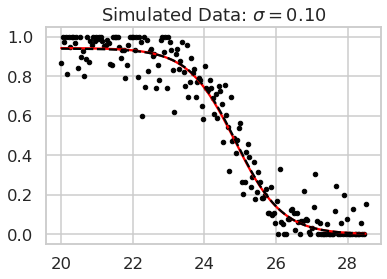

In [11]:
plt.title(r'Simulated Data: $\sigma=%.2f$'%(scatter))
plt.plot(x, y, 'k.', label='data')
plt.plot(x, completeness_formula(x, *popt),'r', label='fit')
plt.plot(x, completeness_formula(x, *args),'k--', label='true')

#### Checking the robustness of the fiting against errors

In [12]:
def create_fake_data(scatter=0.2):
    nargs = args#*(1+scatter*np.random.normal(size=len(args)))
    if nargs[0]>1.: nargs[0] = 1.
    x = mvec
    y = completeness_formula(mvec, *nargs)+scatter*np.random.normal(size=len(mvec))
    
    # truncate the data
    y = np.where(y>1., 1, y)
    y = np.where(y<0., 0., y)
    
    return x, y

In [13]:
noise = 0.1 # 10% noise
nChains = 1000
output = np.zeros((nChains,3),dtype=float )

for i in range(nChains):
    x, y = create_fake_data(scatter=noise)
    popt, pcov = curve_fit(completeness_formula, x, y, p0=[0.9, 24., 0.6], maxfev=2000)
    output[i] = popt

In [14]:
label_args = ['A', r'$m_{50}$', r'$\rho$']

Text(0.5, 0.98, 'Truncated Data -- Noise 10%')

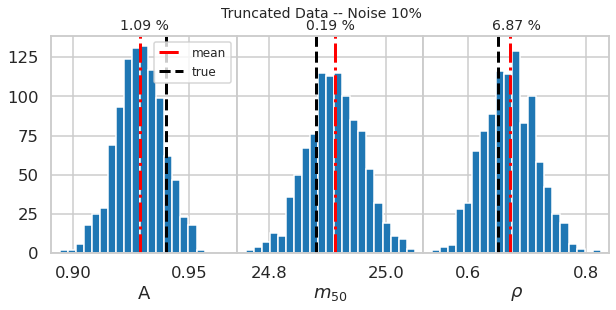

In [15]:
fig, axs = plt.subplots(1,3,figsize=(10, 4), sharey='all')
fig.subplots_adjust(wspace=0.)
for i in range(3):
    mean= np.mean(output[:,i])
    std = np.std(output[:,i])/args[i]
    axs[i].hist(output[:,i],bins=21)
    axs[i].axvline(mean,lw=3,color='r',ls='-.',label='mean')
    axs[i].axvline(args[i],color='k',ls='--',lw=3,label='true')
    axs[i].set_xlabel(label_args[i])
    axs[i].set_title('%.2f %%'%(std*100),fontsize=14)

axs[0].legend(fontsize=12)
fig.suptitle('Truncated Data -- Noise %i%%'%(noise*100),fontsize=14)

## Query Some Fields

I basically use a script to take the gaia data at the same area of the Auxtel detector

In [16]:
# Johnny you need to have a function that for a given field it gives you a table with sources 
# ra, dec, flux, mag, gaia, mag_gaia

In [17]:
collection = 'u/edennihy/tickets/CAP-851'

repo = '/repo/main/butler.yaml'
instrument = 'LATISS'

In [18]:
import lsst.daf.butler as dafButler #Gen3 butler
butler = dafButler.Butler(repo, collections=[collection])
registry=butler.registry

In [19]:
dataset_refs = list(registry.queryDatasets('calexp', collections=[collection]))
dataset_refs = sorted(dataset_refs, key=lambda x : x.dataId['visit'])
expIds = [int(ref.dataId['visit']) for ref in dataset_refs]
len(expIds)

188

In [20]:
from gaia_match import query_wcs_auxtel, query_gaia_data, ploting_field, get_lims
from gaia_match import  sky_match_tables, save_table
import os

def query_data(expId,plot=False):
    print(5*'-----')
    print(f'exposure: {expId}')
    day_obs = int(str(expId)[:8])
    dataId = {"instrument": instrument, "exposure.day_obs": day_obs, "visit": expId, "detector": 0}

    exp = butler.get('calexp', dataId)
    scr = butler.get('src', visit=expId, detector=0, collections=collection).asAstropy()

    # mask = scr['base_CircularApertureFlux_3_0_instFlux']/scr['base_CircularApertureFlux_3_0_instFluxErr'] > 50
    # scr = scr[mask]

    mData = butler.get('raw.metadata', dataId).toDict()

    print('Finding Gaia Sources')
    print('Field %i'%expId)

    print('1 - WCS Solutions')
    # wheader, wcs_auxtel = query_wcs_auxtel(scr, center_ra = mData['RA'], center_dec = mData['DEC'])
    wcsButler = butler.get('calexp.wcs', dataId)
    x0, y0    = wcsButler.getPixelOrigin().getX(), wcsButler.getPixelOrigin().getY()

    print('2 - Gaia Finding')
    tab = query_gaia_data(wcsButler, border = 10, mag_limit=18, row_limit=-1, is_butler=True)

    if plot:
        print('3 - Ploting results')
        ploting_field(tab, scr, exp, expId, x0=x0, y0=y0, path='./figures')

    print('4 - Sky Match Sources And Save Results')
    new = sky_match_tables(tab, scr, wcsButler, radius=1.2, is_butler=True)
    new['EXPID'] = expId
    new['DATE'] = str(mData['DATE'])
    new['FILTER'] = mData['FILTER']
    new['EXPTIME'] = mData['EXPTIME']
    new['X0'] = x0
    new['Y0'] = y0
    return new

In [21]:
expId = expIds[30]
data = query_data(expId,plot=False)

-------------------------
exposure: 2022021500425
Finding Gaia Sources
Field 2022021500425
1 - WCS Solutions
2 - Gaia Finding
185 sources selected on the field
4 - Sky Match Sources And Save Results


In [22]:
data

base_SdssCentroid_x,base_SdssCentroid_y,base_CircularApertureFlux_3_0_instFlux,base_CircularApertureFlux_3_0_instFluxErr,ra,dec,gaia,id_match,source_id,ref_ra,ref_dec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,radius_val,ref_base_SdssCentroid_x,ref_base_SdssCentroid_y,dist,auxtel,EXPID,DATE,FILTER,EXPTIME,X0,Y0
pix,pix,ct,ct,,,,,,deg,deg,mag,mag,mag,solRad,,,,,,,,,,
float64,float64,float64,float64,float64,float64,bool,int64,int64,float64,float64,float32,float32,float32,float32,float64,float64,float64,bool,int64,str23,str5,float64,float64,float64
99.0,17.0,263.0103454589844,74.01245880126953,221.8532969366933,-45.29405015914106,False,-2,--,--,--,--,--,--,--,--,--,--,--,2022021500425,2022-02-16T06:25:05.188,SDSSg,30.0,2088.0000000000005,2005.9999999999998
1772.9436931600678,2880.728480647055,362.75958251953125,65.99925994873047,221.91517808648874,-45.21737487749802,False,-2,--,--,--,--,--,--,--,--,--,--,--,2022021500425,2022-02-16T06:25:05.188,SDSSg,30.0,2088.0000000000005,2005.9999999999998
1846.2202699310599,2888.169707596861,337.6748962402344,66.40161895751953,221.91794007551866,-45.21715290188995,False,-2,--,--,--,--,--,--,--,--,--,--,--,2022021500425,2022-02-16T06:25:05.188,SDSSg,30.0,2088.0000000000005,2005.9999999999998
2578.9961882268526,3584.924583273767,-25.05571937561035,55.539676666259766,221.94525055130268,-45.19838254427703,False,-2,--,--,--,--,--,--,--,--,--,--,--,2022021500425,2022-02-16T06:25:05.188,SDSSg,30.0,2088.0000000000005,2005.9999999999998
290.3702548108861,2898.030139866272,310.8082275390625,61.408447265625,221.8592148499912,-45.21738865200056,False,-2,--,--,--,--,--,--,--,--,--,--,--,2022021500425,2022-02-16T06:25:05.188,SDSSg,30.0,2088.0000000000005,2005.9999999999998
3951.0,3880.0,-72.32952117919922,56.973270416259766,221.99686097315043,-45.19006072461521,False,-2,--,--,--,--,--,--,--,--,--,--,--,2022021500425,2022-02-16T06:25:05.188,SDSSg,30.0,2088.0000000000005,2005.9999999999998
178.02542143503598,2897.96372660872,254.27288818359375,63.63425064086914,221.85497475509433,-45.217425206967796,False,-2,--,--,--,--,--,--,--,--,--,--,--,2022021500425,2022-02-16T06:25:05.188,SDSSg,30.0,2088.0000000000005,2005.9999999999998
217.0,2898.0,166.14398193359375,61.60409164428711,221.85644571994177,-45.217412191265886,False,-2,--,--,--,--,--,--,--,--,--,--,--,2022021500425,2022-02-16T06:25:05.188,SDSSg,30.0,2088.0000000000005,2005.9999999999998


### Defining Variables
Let's define magnitudes for the AuxTel images:

$$
m - m_{ref} = -2.5 \times Log\left(\frac{I}{I_{ref}} \right)
$$

For now I'm using $m_{ref}=20$ and $I_{ref}$ is derived from the data. 

To do list:
    <li> compute residuals
    <li> detect outliers
    <li> iterate algorithm
    </li>
  

In [23]:
## Define all masks
gaia = np.isfinite(data['ref_ra'])# & rect_mask
auxtel = np.isfinite(data['base_SdssCentroid_x'])
only_gaia = np.isnan(data['base_CircularApertureFlux_3_0_instFlux'])# & rect_mask
only_auxtel = (np.isnan(data['ref_ra']))
matched = (data['id_match']>0.) #& rect_mask
good = (data['base_CircularApertureFlux_3_0_instFlux']/data['base_CircularApertureFlux_3_0_instFluxErr'] > 5.) | only_gaia


In [24]:
mag_gaia = np.array(data['phot_g_mean_mag'])
flux = np.array(data['base_CircularApertureFlux_3_0_instFlux'])
log_flux = np.log10(flux)

flux_gt0 = log_flux>0.

/tmp/ipykernel_74925/3695565253.py:3: RuntimeWarning: invalid value encountered in log10
  log_flux = np.log10(flux)


275.781036376953


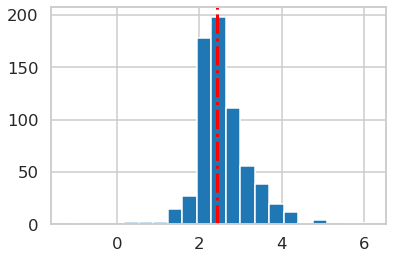

In [25]:
import statistics

log_fref = np.nanmedian(log_flux)
print(10**log_fref)
_ = plt.hist(log_flux,bins=21)
plt.axvline(log_fref,ls='-.',lw=3,color='r')

In [26]:
mag_ref = 20.
mag_woRef = -2.5*(log_flux-log_fref)
mag = mag_woRef+mag_ref

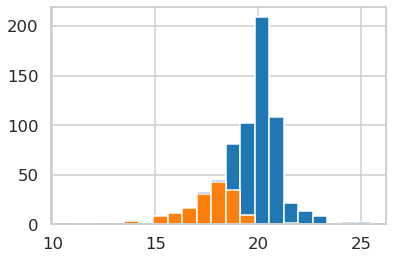

In [27]:
a = plt.hist(mag[auxtel&flux_gt0],bins=21)
_ = plt.hist(mag[matched&flux_gt0],bins=a[1])

## Fiting: binned data

In [28]:
from utils import compute_fraction_err, plot_curve

In [29]:
def compute_frac_bins_per_exposure(mag, mag_bins, mask1, mask2, keys):
    mbins = 0.5*(mag_bins[1:]+mag_bins[:-1])

    frac = np.empty((len(mbins),len(keys)), dtype=float)
    for i,ix in enumerate(keys):
        denominator = np.histogram(mag[ix[mask1[ix]]],bins=mag_bins)[0]
        numerator   = np.histogram(mag[ix[mask2[ix]]],bins=mag_bins)[0]

        frac[:,i] = numerator/np.where(denominator<2,np.nan,denominator)

    return mbins, frac

In [30]:
keys = [np.arange(0,len(data),dtype=int)]

In [31]:
xfit = np.empty((0,),dtype=float)
yfit = np.empty((0,),dtype=float)
for dm in [0.1]:
    mag_bins = np.arange(15.25,22.5+dm,dm)
    # mag_bins = np.array([9.,12.,14.0,15.0,16.0,17.,18.])
    # for li,mask in mask_list.items():
    mbins, frac = compute_frac_bins_per_exposure(mag, mag_bins, 
                                                 (auxtel&flux_gt0), (matched&flux_gt0), keys)
    xfit = np.append(xfit,mbins)
    yfit = np.append(yfit,frac)

In [32]:
nnan = ~np.isnan(yfit)
popt, pcov = curve_fit(completeness_formula, xfit[nnan], yfit[nnan], p0=[1.0, 17.5, 0.6], maxfev=2000)
popt

array([ 0.98850388, 18.78408464,  0.21922235])

Text(0.5, 1.0, 'Fist Interation')

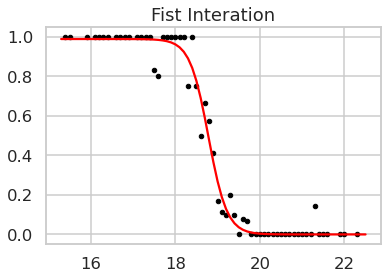

In [33]:
idx = np.argsort(xfit)
ynew = completeness_formula(xfit[idx], *popt)

plt.plot(xfit[idx], yfit[idx], 'k.')
plt.plot(xfit[idx], ynew,'r', label='fit')
plt.title('Fist Interation')

In [34]:
def get_nmad(x,scale=1.48):
    nmad = scale*np.nanmedian(np.abs(x-np.nanmedian(x)))
    return nmad

def get_outliers(x,ns=2):
    q1, q3 = np.nanpercentile(x,[25,75])
    iqr = 0.5*(q3-q1)
    vlow, vhig = q1-ns*iqr, q3+ns*iqr
    return vlow, vhig

In [35]:
residuals = yfit-completeness_formula(xfit, *popt)
std_residuals = (residuals-np.nanmedian(residuals))/np.nanstd(residuals)#np.sqrt(ss_res)
# vlow, vhig = get_outliers(std_residuals,ns=5.)
# vlow, vhig

In [36]:
outliers = np.abs(std_residuals)>2.
nnan = ~(np.isnan(yfit)|outliers)
popt, pcov = curve_fit(completeness_formula, xfit[nnan], yfit[nnan], p0=[1.0, 17.5, 0.6], maxfev=2000)
popt

array([ 1.00350534, 18.80534327,  0.19628625])

In [37]:
label = r''
for i in range(3):
    label+= '%s = %.3f \n'%(label_args[i], popt[i])
print(label)

A = 1.004 
$m_{50}$ = 18.805 
$\rho$ = 0.196 



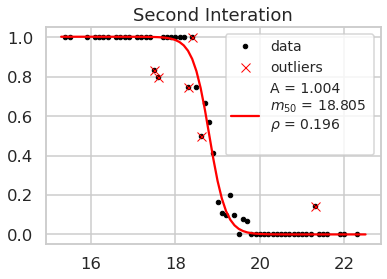

In [38]:
idx = np.argsort(xfit)
plt.plot(xfit[idx], yfit[idx], 'k.',label='data')
plt.plot(xfit[~nnan], yfit[~nnan], 'rx',label='outliers')
plt.plot(xfit[idx], completeness_formula(xfit[idx], *popt),'r', label=label)
plt.title('Second Interation')
plt.legend(fontsize=14)

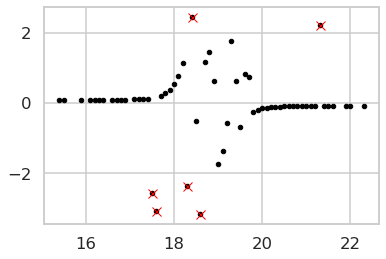

In [39]:
plt.plot(xfit[idx], std_residuals[idx], 'k.',label='data')
plt.plot(xfit[~nnan], std_residuals[~nnan], 'rx',label='outliers')

In [40]:
def fit_completeness(xfit,yfit,nRun=5, verbose=False):
    nnan = ~np.isnan(yfit)
    popt = [1.0, 18.5, 0.2]
    for i in range(nRun):
        popt, pcov = curve_fit(completeness_formula, xfit[nnan], yfit[nnan], p0=popt, maxfev=3000)
        ynew = completeness_formula(xfit, *popt)
        residuals = yfit-ynew
        std_residuals = (residuals-np.nanmedian(residuals))/get_nmad(residuals[np.abs(residuals)<1.])
        vlow, vhig = get_outliers(std_residuals[np.abs(residuals)<1.],ns=1.5)
        
        ss_tot = np.sum((yfit[nnan]-np.nanmedian(yfit[nnan]))**2)
        rsqr = 1-(np.sum(residuals[nnan]**2)/ss_tot)
        
        outliers = (std_residuals<vlow)|(std_residuals>vhig)
        nnan = ~(np.isnan(yfit)|outliers)
        if verbose:
            print('Iteration %i'%i)
            print(f'pars: {popt}')
            print(f'R^2: {rsqr:.5f}')
            print(f'lims: {vlow}, {vhig}')
            print(f'# outliers: {np.count_nonzero(outliers)}')
            print('\n')
    
    return popt, pcov, nnan, rsqr

In [41]:
popt, pcov, mask, r2 = fit_completeness(xfit, yfit, nRun=3, verbose=True)

Iteration 0
pars: [ 0.98850391 18.7840847   0.2192226 ]
R^2: 0.98371
lims: -1.709256101071024, 1.9357387799984849
# outliers: 22


Iteration 1
pars: [ 1.         18.65856047  0.02407507]
R^2: 1.00000
lims: -8.936325816791142e+18, 2.0851426905845998e+19
# outliers: 20


Iteration 2
pars: [ 1.         18.65856047  0.02407507]
R^2: 1.00000
lims: -8.936325816791142e+18, 2.0851426905845998e+19
# outliers: 20




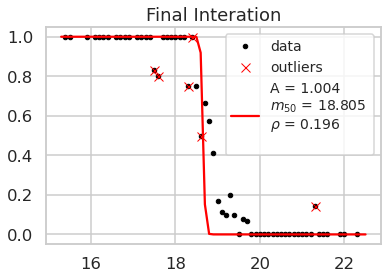

In [42]:
idx = np.argsort(xfit)
plt.plot(xfit[idx], yfit[idx], 'k.',label='data')
plt.plot(xfit[~nnan], yfit[~nnan], 'rx',label='outliers')
plt.plot(xfit[idx], completeness_formula(xfit[idx], *popt),'r', label=label)
plt.title('Final Interation')
plt.legend(fontsize=14)

In [43]:
p0 = popt
pc0 = pcov

## Fiting: KDE+Resampling+Iterative

## KDE+Iterative

In [44]:
from sklearn.neighbors import KernelDensity
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

def compute_fraction_kde_sklearn(xvec, x, mask1, mask2, bw=None, rtol=1e-6, kernel='gaussian', eps=1e-6):
    mbins = 0.5*(mag_bins[1:]+mag_bins[:-1])
    N1, N2 = len(x[mask1]), len(x[mask2])
    numerator = N2*kde_sklearn(x[mask2], xvec, bandwidth=bw, rtol=rtol, kernel=kernel)
    denumerator = N1*kde_sklearn(x[mask1], xvec, bandwidth=bw, rtol=rtol, kernel=kernel)+eps
    frac = numerator/denumerator
    return mbins, np.where(frac>1., np.nan, frac)

def sample_vec(x):
    idx = np.random.randint(0,x.size,size=x.size,dtype=int)
    return idx

In [45]:
nResample = 10
# dm = 0.05
# mag_bins = np.arange(15.25,22.5+dm,dm)

# xfit = np.empty((0,),dtype=float)
# yfit = np.empty((0,),dtype=float)
# for i in range(nResample):
#     idx = sample_vec(mag) # similar to: df.sample(frac=1, replace=True)
#     #frac = compute_fraction_kde_sklearn(mvec, mag[idx], mask[idx], bw=bw)
#     _, frac = compute_fraction_kde_sklearn(mag_bins, mag[idx], 
#                                                  (auxtel[idx]&flux_gt0[idx]), (matched[idx]&flux_gt0[idx]), bw=0.1)
#     xfit = np.append(xfit,mag_bins)
#     yfit = np.append(yfit,frac)

In [46]:
_, frac = compute_fraction_kde_sklearn(mag_bins, mag, 
                                             (auxtel&flux_gt0), (matched&flux_gt0), bw=0.1)
yfit = frac
xfit = mag_bins

In [47]:
nnan = ~np.isnan(yfit)
popt, pcov = curve_fit(completeness_formula, xfit[nnan], yfit[nnan], p0=[1.0, 17.5, 0.6], maxfev=2000)
popt

array([ 0.99115463, 18.79004754,  0.22200856])

Text(0.5, 1.0, 'Fist Interation')

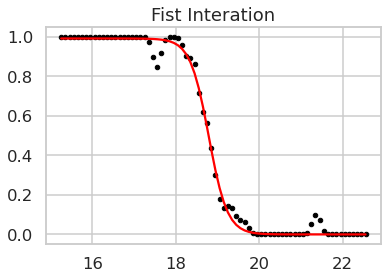

In [48]:
idx = np.argsort(xfit)
ynew = completeness_formula(xfit[idx], *popt)

plt.plot(xfit[idx], yfit[idx], 'k.')
plt.plot(xfit[idx], ynew,'r', label='fit')
plt.title('Fist Interation')

In [49]:
residuals = yfit-completeness_formula(xfit, *popt)
std_residuals = (residuals-np.nanmedian(residuals))/np.nanstd(residuals)#np.sqrt(ss_res)
# vlow, vhig = get_outliers(std_residuals,ns=5.)
# vlow, vhig

In [50]:
outliers = np.abs(std_residuals)>2.
nnan = ~(np.isnan(yfit)|outliers)
popt, pcov = curve_fit(completeness_formula, xfit[nnan], yfit[nnan], p0=[1.0, 17.5, 0.6], maxfev=2000)
popt

array([ 1.0020284 , 18.78371247,  0.22425853])

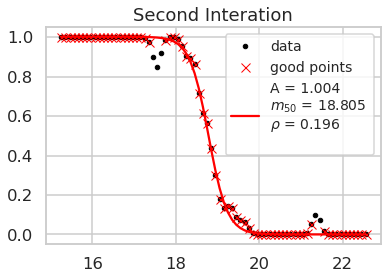

In [51]:
plt.plot(xfit[idx], yfit[idx], 'k.',label='data')
plt.plot(xfit[nnan], yfit[nnan], 'rx',label='good points')
plt.plot(xfit[idx], completeness_formula(xfit[idx], *popt),'r', label=label)
plt.title('Second Interation')
plt.legend(fontsize=14)

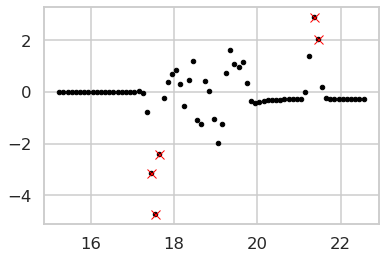

In [52]:
plt.plot(xfit[idx], std_residuals[idx], 'k.',label='data')
plt.plot(xfit[~nnan], std_residuals[~nnan], 'rx',label='outliers')

In [53]:
popt, pcov, mask, r2 = fit_completeness(xfit, yfit, nRun=5, verbose=True)

Iteration 0
pars: [ 0.99115455 18.79004711  0.22200756]
R^2: 0.99558
lims: -1.2281569252773343, 0.5791305771494861
# outliers: 26


Iteration 1
pars: [ 0.99965854 18.79570611  0.2213711 ]
R^2: 0.99998
lims: -1.5263521744128, 1.538214804033698
# outliers: 33


Iteration 2
pars: [ 0.9999309  18.80180577  0.19781538]
R^2: 1.00000
lims: -2.1260249106132276, 1.2530816069162714
# outliers: 34


Iteration 3
pars: [ 0.99999521 18.82411257  0.1062155 ]
R^2: 1.00000
lims: -4.06028584231888, 7.635622520413103
# outliers: 35


Iteration 4
pars: [ 0.99999983 18.82392031  0.10700076]
R^2: 1.00000
lims: -4.0710855366824035, 8.90324856516917
# outliers: 35




In [54]:
label = r''
for i in range(3):
    label+= '%s = %.3f \n'%(label_args[i], popt[i])
print(label)

A = 1.000 
$m_{50}$ = 18.824 
$\rho$ = 0.107 



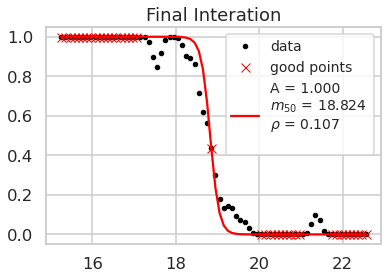

In [55]:
plt.plot(xfit[idx], yfit[idx], 'k.',label='data')
plt.plot(xfit[mask], yfit[mask], 'rx',label='good points')
plt.plot(xfit[idx], completeness_formula(xfit[idx], *popt),'r', label=label)
plt.title('Final Interation')
plt.legend(fontsize=14)

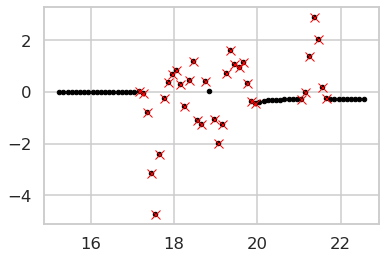

In [56]:
plt.plot(xfit[idx], std_residuals[idx], 'k.',label='data')
plt.plot(xfit[~mask], std_residuals[~mask], 'rx',label='outliers')

### With 5 Iterations

In [57]:
def bin_kde_bootstrap(x, mvec, mask1, mask2, bw=0.1, nBootStrap=10):
    nsize = len(mvec)
    frac = np.full((nsize, nBootStrap), np.nan)
    mbins= np.full((nsize, nBootStrap), np.nan)
    for i in range(nBootStrap):
        idx = sample_vec(x) # similar to: df.sample(frac=1, replace=True)
        _, fr = compute_fraction_kde_sklearn(mvec, x[idx], 
                                            (mask1[idx]), (mask2[idx]), bw=bw)
        frac[:,i] = fr
        mbins[:,i] = mvec
    return mbins, frac

In [58]:
dm=0.05
mag_bins = np.arange(15.25, 22.+dm, dm)
mb, fb = bin_kde_bootstrap(mag, mag_bins, auxtel&flux_gt0, matched&flux_gt0, bw=0.15, nBootStrap=200)

xfit = mb.flatten()
yfit = fb.flatten()

In [59]:
popt, pcov, mask, r2 = fit_completeness(xfit, yfit)

In [60]:
label = r''
for i in range(3):
    label+= '%s = %.3f \n'%(label_args[i], popt[i])
print(label)

A = 1.000 
$m_{50}$ = 18.782 
$\rho$ = 0.237 



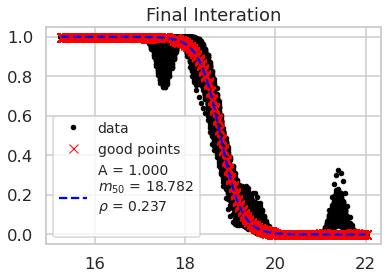

In [61]:
idx = np.argsort(xfit)
plt.plot(xfit[idx], yfit[idx], 'k.',label='data')
plt.plot(xfit[idx][mask[idx]], yfit[idx][mask[idx]], 'rx',label='good points')
plt.plot(xfit[idx], completeness_formula(xfit[idx], *popt),'b--', label=label)
plt.title('Final Interation')
plt.legend(fontsize=14)

In [62]:
p1 = popt
pc1= pcov

## Fiting: KDE+BootStrap+Iterative

In [63]:
def fit_completeness_bootstrap(x, mvec, mask1, mask2, bw=0.1, nBootStrap=10):
    nsize = 3
    popt = np.full((nsize, nBootStrap), np.nan)
    r2 = np.full((1, nBootStrap), np.nan)
    for i in range(nBootStrap):
        idx = sample_vec(x) # similar to: df.sample(frac=1, replace=True)
        _, yfit = compute_fraction_kde_sklearn(mvec, x[idx], mask1[idx], mask2[idx], bw=bw)
        #plt.scatter(mvec,yfit*100)
        try:
            popti, _, _, ri = fit_completeness(mvec, yfit)
            popt[:,i] = popti
            r2[:,i] = ri
        except:
            print('Error')
    
    return popt, r2

In [64]:
dm=0.05
mag_bins = np.arange(15.25, 22.+dm, dm)
popts, r2s = fit_completeness_bootstrap(mag, mag_bins, auxtel&flux_gt0, matched&flux_gt0, bw=0.15, nBootStrap=1000)


Text(0.5, 0.98, 'Expid 2022021500425 - BootStrap -- 1000 realizations')

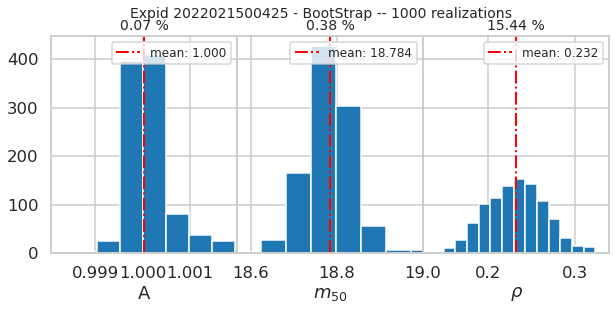

In [65]:
fig, axs = plt.subplots(1,3,figsize=(10, 4), sharey='all')
fig.subplots_adjust(wspace=0.)
nnan = np.isnan(r2s[0])

prec = []
means = []
for i in range(3):
    x = popts[i][~nnan]
    mean= np.median(x)
    std = np.std(x)/mean
    axs[i].hist(x,bins=21)
    axs[i].axvline(mean,lw=2,color='r',ls='-.',label='mean: %.3f'%(mean))
    #axs[i].axvline(args[i],color='k',ls='--',lw=3,label='true')
    axs[i].set_xlabel(label_args[i])
    axs[i].set_title('%.2f %%'%(std*100),fontsize=14)
    axs[i].legend(fontsize=12)
    axs[i].set_xlim(mean-3*std*mean,mean+3*std*mean)
    prec.append(std*mean)
    means.append(mean)
fig.suptitle(f'Expid {expId} - BootStrap -- 1000 realizations',fontsize=14)

In [66]:
p3 = means
pc3 = prec

In [67]:
prec

[0.0006533127153364209, 0.07211437126932052, 0.03587745458970842]

## Compare Methods

Text(0.5, 1.0, '$\\rho$')

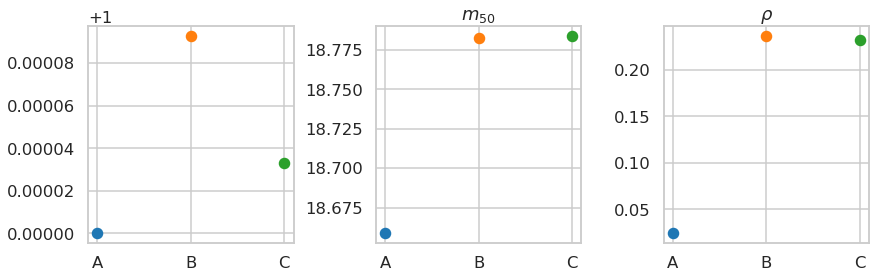

In [68]:
fig, axs = plt.subplots(1,3,figsize=(14, 4))
fig.subplots_adjust(wspace=0.4)

i = 0
axs[i].scatter('A',p0[i],s=100)
axs[i].scatter('B',p1[i],s=100)
axs[i].scatter('C',p3[i],s=100)
# axs[i].errorbar('A',p0[i],yerr=pc0[i][i])
# axs[i].errorbar('B',p1[i],yerr=pc1[i][i])
# axs[i].errorbar('C',p3[i],yerr=pc3[i])

i = 1
axs[i].scatter('A',p0[i],s=100)
axs[i].scatter('B',p1[i],s=100)
axs[i].scatter('C',p3[i],s=100)
# axs[i].errorbar('A',p0[i],yerr=pc0[i][i])
# axs[i].errorbar('B',p1[i],yerr=pc1[i][i])
# axs[i].errorbar('C',p3[i],yerr=pc3[i])

axs[i].set_title(label_args[i])

i = 2
axs[i].scatter('A',p0[i],s=100)
axs[i].scatter('B',p1[i],s=100)
axs[i].scatter('C',p3[i],s=100)
# axs[i].errorbar('A',p0[i],yerr=pc0[i][i])
# axs[i].errorbar('B',p1[i],yerr=pc1[i][i])
# axs[i].errorbar('C',p3[i],yerr=pc3[i])

axs[i].set_title(label_args[i])